# Ch 3c: Design Patterns 9 and 10

Design Pattern 9: Neutral Class

Design Pattern 10: Rebalancing

# Design Pattern 9: Neutral Class

Demostrates on a synthetic dataset that creating a separate Neutral class can be helpful. And then provides a real-world scenario

## On Synthetic data

Patients with a history of jaundice will be assumed to be at risk of liver damage and prescribed ibuprofen while patients with a history of stomach ulcers will be prescribed acetaminophen. The remaining patients will be arbitrarily assigned to either category.

In [1]:
import numpy as np
import pandas as pd
from dotenv import load_dotenv
from pathlib import Path
import os

load_dotenv(dotenv_path=Path("../.env"))

True

In [2]:
%load_ext google.cloud.bigquery
from google.cloud import bigquery
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = f"../{os.environ.get('GCP_KEY_FILE')}"
bq = bigquery.Client()

In [ ]:
# dataset = bq.create_dataset("mlpatterns")

In [3]:
def create_synthetic_dataset(N, shuffle):
  # random array
  prescription = np.full(N, fill_value='acetominophen', dtype='U20')
  prescription[:N//2] = 'ibuprofen'
  np.random.shuffle(prescription)
  
  # neutral class
  p_neutral = np.full(N, fill_value='Neutral', dtype='U20')

  # 10% is patients with history of liver disease
  jaundice = np.zeros(N, dtype=bool)
  jaundice[0:N//10] = True
  prescription[0:N//10] = 'ibuprofen'
  p_neutral[0:N//10] = 'ibuprofen'

  # 10% is patients with history of stomach ulcers
  ulcers = np.zeros(N, dtype=bool)
  ulcers[(9*N)//10:] = 'acetominophen'
  prescription[(9*N)//10:] = 'acetominophen'
  p_neutral[(9*N)//10:] = 'acetominophen'

  df = pd.DataFrame.from_dict({
    'jaundice': jaundice,
    'ulcers': ulcers,
    'prescription': prescription,
    'prescription_with_neutral': p_neutral
  })

  if shuffle:
    return df.sample(frac=1).reset_index(drop=True)
  else:
    return df

In [4]:
df = create_synthetic_dataset(1000, shuffle=True)
df.head()

,jaundice,ulcers,prescription,prescription_with_neutral
0,False,False,ibuprofen,Neutral
1,False,False,acetominophen,Neutral
2,False,False,acetominophen,Neutral
3,False,False,ibuprofen,Neutral
4,True,False,ibuprofen,ibuprofen


In [5]:
from sklearn import linear_model
for label in ['prescription', 'prescription_with_neutral']:
  ntrain = 8*len(df)//10 # 80% used as training data
  lm = linear_model.LogisticRegression()
  lm = lm.fit(df.loc[:ntrain-1, ['jaundice', 'ulcers']], df[label][:ntrain])
  acc = lm.score(df.loc[ntrain:, ['jaundice', 'ulcers']], df[label][ntrain:])
  print(f'label={label} | accuracy={acc}')

label=prescription | accuracy=0.6
label=prescription_with_neutral | accuracy=1.0


## On Natality data

A baby with an Apgar score of 10 is healthy and one with an Apgar score of <= 7 requires some medical attention. What about babies with scores of 8-9? They are neither perfectly healthy, nor do they need serious medical intervention. Let's see how the model does with a 2-class model and with a 3-class model that includes a Neutral class.

Without the Neutral class

In [19]:
%%bigquery
CREATE OR REPLACE MODEL `mlpatterns.neutral_2classes`
OPTIONS(model_type='logistic_reg', input_label_cols=['health']) AS
SELECT
	IF(apgar_1min >= 9, 'Healthy', 'NeedsAttention') AS health,
	plurality,
	mother_age,
	gestation_weeks,
	ever_born
FROM `bigquery-public-data.samples.natality`
WHERE apgar_1min <= 10

""


In [20]:
%%bigquery
SELECT * FROM ML.EVALUATE(MODEL mlpatterns.neutral_2classes)

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.565628,0.997893,0.565213,0.722007,0.690348,0.52722


Create a neutral class to hold "marginal" scores (8-9) These represents babies that are neither perfectly healthy or require serious medical intervention

In [9]:
%%bigquery
CREATE OR REPLACE MODEL mlpatterns.neutral_3classes
OPTIONS(model_type='logistic_reg', input_label_cols=['health'])
AS

SELECT
	IF (apgar_1min = 10, 'Healthy',
  IF (apgar_1min >= 8, 'Neutral', 'Needs Attention')
	) AS health,
	plurality,
	mother_age,
 	gestation_weeks,
  ever_born
FROM `bigquery-public-data.samples.natality`
WHERE apgar_1min <= 10

""


The second model which includes the neutral data class has an accurayc of 0.79 vs. the original which is around 0.56

# Design Pattern 10: Rebalancing

Handle datasets that are inherently imbalanced

dataset: https://www.kaggle.com/datasets/ealaxi/paysim1?resource=download

## Downsampling

In [1]:
import itertools
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import xgboost as xgb

from tensorflow import keras
from tensorflow.keras import Sequential

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle

In [7]:
fraud_data = pd.read_csv("data/synthetic_financial.csv")
fraud_data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [8]:
# Drop columns that aren't used
fraud_data = fraud_data.drop(columns=['nameOrig', 'nameDest', 'isFlaggedFraud'])

# Create dummy variables for categorical features
fraud_data = pd.get_dummies(fraud_data)

# Split into fraud and not fraud
fraud = fraud_data[fraud_data['isFraud'] == 1]
not_fraud = fraud_data[fraud_data['isFraud'] == 0]

# Take random sample of not fraud data
# 	a 0.005 pct will give an 80/20 split for fraud/ not fraud
#   this is because there are just too many not fraud datapoints
not_fraud_sample = not_fraud.sample(random_state=42, frac=0.005)

# Put dataframe back
fraud_data = pd.concat([not_fraud_sample, fraud])
frad_data = shuffle(fraud_data, random_state=42)

fraud_data['isFraud'].value_counts()

0    31772
1     8213
Name: isFraud, dtype: int64

In [9]:
# Create train and test sets
split = int(fraud_data.shape[0] * 0.8)

train = frad_data[:split]
test = frad_data[split:]

train_labels = train.pop('isFraud')
test_labels = test.pop('isFraud')

In [19]:
model = xgb.XGBClassifier()

model.fit(train.values, train_labels)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [22]:
y_pred = model.predict(test.values)

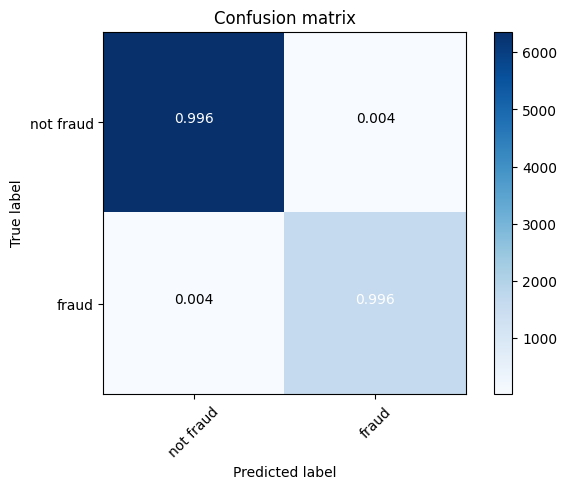

In [24]:
# Create confusion matrix
cm = confusion_matrix(test_labels.values, y_pred)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
	"""
	This function prints and plots the confusion matrix.
	Normalization can be applied by setting `normalize=True`.
	"""
	plt.imshow(cm, interpolation='nearest', cmap=cmap)
	plt.title(title)
	plt.colorbar()
	tick_marks = np.arange(len(classes))
	plt.xticks(tick_marks, classes, rotation=45)
	plt.yticks(tick_marks, classes)

	if normalize:
			cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 3)

	thresh = cm.max() / 2.
	for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
			plt.text(j, i, cm[i, j],
								horizontalalignment="center",
								color="white" if cm[i, j] > thresh else "black")

	plt.tight_layout()
	plt.ylabel('True label')
	plt.xlabel('Predicted label')

classes = ['not fraud', 'fraud']
plot_confusion_matrix(cm, classes, normalize=True)

## Weighted classes and output bias

Use different fraud detection dataset from BigQuery with fewer minority class examples

In [15]:
# bq.create_dataset('fraud')

Dataset(DatasetReference('blissful-hash-268906', 'fraud'))

In [5]:
%%bigquery fraud_df
SELECT *
FROM
	`bigquery-public-data.ml_datasets.ulb_fraud_detection`
WHERE Class = 1

In [6]:
%%bigquery nonfraud_df
SELECT *
FROM
	`bigquery-public-data.ml_datasets.ulb_fraud_detection`
WHERE Class = 0
AND RAND() < 0.05

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.238561,-10.645800,5.918307,-11.671043,8.807369,-7.975501,-3.586806,-13.616797,6.428169,-7.368451,...,2.571970,0.206809,-1.667801,0.558419,-0.027898,0.354254,0.273329,-0.152908,0.000000,1
1,0.487286,-0.937843,3.462889,-6.445104,4.932199,-2.233983,-2.291561,-5.695594,1.338825,-4.322377,...,1.066550,-0.521657,-0.319917,-0.405859,0.906802,1.165784,1.374495,0.729889,0.000000,1
2,0.487286,-0.937843,3.462889,-6.445104,4.932199,-2.233983,-2.291561,-5.695594,1.338825,-4.322377,...,1.066550,-0.521657,-0.319917,-0.405859,0.906802,1.165784,1.374495,0.729889,0.000000,1
3,0.493543,-7.030308,3.421991,-9.525072,5.270891,-4.024630,-2.865682,-6.989195,3.791551,-4.622730,...,1.103398,-0.541855,0.036943,-0.355519,0.353634,1.042458,1.359516,-0.272188,0.000000,1
4,0.890557,-0.613696,3.698772,-5.534941,5.620486,1.649263,-2.335145,-0.907188,0.706362,-3.747646,...,0.319261,-0.471379,-0.075890,-0.667909,-0.642848,0.070600,0.488410,0.292345,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14112,0.301056,1.065351,0.104054,0.505197,1.501993,-0.333553,-0.356230,0.141263,-0.058649,0.235934,...,-0.054139,-0.000809,-0.059304,0.415390,0.611046,-0.337273,0.034145,0.026505,0.006095,0
14113,0.292056,1.002321,0.073574,0.071632,1.001350,0.000882,-0.286163,0.328591,0.022708,-0.378345,...,-0.266449,-1.015916,0.095276,-0.048126,0.250663,-0.736013,-0.003370,0.023597,0.011172,0
14114,0.456140,1.261390,-0.183591,0.133266,-0.927003,-0.585001,-0.944967,-0.116707,-0.070793,1.324207,...,-0.042278,-0.019505,-0.003108,0.052851,0.519649,-0.725241,0.060816,0.018533,0.000099,0
14115,0.783191,-1.845673,1.647348,-0.033797,-0.891151,-0.393727,-0.243331,-0.609895,1.382118,-0.481351,...,0.001932,-0.416445,0.127020,0.658559,-0.253588,-0.350747,-0.474615,-0.098647,0.000167,0


In [16]:
# Setup Dataset
bq_fraud_data = pd.concat([fraud_df, nonfraud_df], axis=0)
bq_fraud_data.sort_values(by=['Time'])

# Scale time and amount values
time_scaler = MinMaxScaler()
amt_scaler = MinMaxScaler()

bq_fraud_data['Time'] = time_scaler.fit_transform(bq_fraud_data['Time'].values.reshape(-1, 1))
bq_fraud_data['Amount'] = amt_scaler.fit_transform(bq_fraud_data['Amount'].values.reshape(-1, 1))

bq_fraud_data['Class'].value_counts()

0    14117
1      492
Name: Class, dtype: Int64

In [28]:
# Split dataset
train_test_split = int(len(bq_fraud_data) * .8)

train_data = bq_fraud_data[:train_test_split]
test_data = bq_fraud_data[train_test_split:]

train_labels = train_data.pop('Class')
test_labels = test_data.pop('Class')

# Create tf dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_data.values, np.asarray(train_labels).astype(np.float32)))
train_dataset = train_dataset.shuffle(len(train_data)).batch(1024)

test_dataset = tf.data.Dataset.from_tensor_slices((test_data.values, np.asarray(test_labels).astype(np.float32)))
test_dataset = test_dataset.shuffle(len(test_data)).batch(1)

For the weighted class, add a bias initializer to the output layer

In [30]:
# Get number of examples for each class from training set
num_minority = train_labels.value_counts()[1]
num_majority = train_labels.value_counts()[0]

# Calculate weight
minority_class_weight = 1 / (num_minority / len(train_data)) / 2
majority_class_weight = 1 / (num_majority / len(train_data)) / 2

# Pass weights to keras in a dict
keras_class_weights = {
  0: majority_class_weight,
  1: minority_class_weight
}
print(keras_class_weights)

# Calculate output bias
output_bias = math.log(num_minority / num_majority)
print(output_bias)

{0: 0.5219740955783833, 1: 11.877032520325203}
-3.124743812540547


In [31]:
# Build the fraud model
fraud_model = keras.Sequential([
  keras.layers.Dense(16, input_shape=(len(train_data.iloc[0]), ), activation='relu'),
  keras.layers.Dropout(0.25),
  keras.layers.Dense(16, activation='relu'),
  keras.layers.Dense(1, activation='sigmoid', bias_initializer=tf.keras.initializers.Constant(output_bias))
])

# Metrics
metrics = [
  tf.keras.metrics.BinaryAccuracy(name='accuracy'),
  tf.keras.metrics.Precision(name='precision'),
  tf.keras.metrics.Recall(name='recall'),
  tf.keras.metrics.AUC(name='roc_auc'),
]

In [32]:
fraud_model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=metrics
)

fraud_model.fit(
  train_dataset,
  validation_data=test_dataset,
  epochs=10, 
  class_weight=keras_class_weights
)

Epoch 1/10
12/12 [==============================] - 18s 1s/step - loss: 2.0568 - accuracy: 0.9595 - precision: 1.0000 - recall: 0.0386 - roc_auc: 0.4473 - val_loss: 0.0412 - val_accuracy: 0.9997 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.0000e+00
Epoch 2/10
12/12 [==============================] - 16s 1s/step - loss: 1.1647 - accuracy: 0.9674 - precision: 0.9826 - recall: 0.2297 - roc_auc: 0.7310 - val_loss: 0.0544 - val_accuracy: 0.9993 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.0000e+00
Epoch 3/10
12/12 [==============================] - 15s 1s/step - loss: 0.6378 - accuracy: 0.9775 - precision: 0.9321 - recall: 0.5020 - roc_auc: 0.8723 - val_loss: 0.0713 - val_accuracy: 0.9973 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.0000e+00
Epoch 4/10
12/12 [==============================] - 16s 1s/step - loss: 0.4357 - accuracy: 0.9831 - precision: 0.9200 - recall: 0.6545 - roc_auc: 0.9263 - val_loss: 0.0885 - val_

# Reframing

__Use cluster distance as a prediction signal__

train a clustering model and use the distance of new examples from clusters to detect anomalies. We'll train a kmeans model on the natality dataset to demonstrate this.

In [3]:
%%bigquery
CREATE OR REPLACE MODEL `mlpatterns.baby_weight_clusters`
OPTIONS(model_type='kmeans', num_clusters=4) AS
SELECT
  weight_pounds,
  mother_age,
  gestation_weeks
FROM
  `bigquery-public-data.samples.natality`
LIMIT 10000

""


Look at the cluster prediction for the "average" example in the dataset

In [11]:
%%bigquery average_pred
SELECT * FROM
  ML.PREDICT (MODEL `mlpatterns.baby_weight_clusters`,
  (
    SELECT
      7.0 as weight_pounds,
      28 as mother_age,
      40 as gestation_weeks
  )
);

In [12]:
average_pred

,CENTROID_ID,NEAREST_CENTROIDS_DISTANCE,weight_pounds,mother_age,gestation_weeks
0,1,"[{'CENTROID_ID': 1, 'DISTANCE': 0.969667832380...",7.0,28,40


Comparing this with a cluster prediction from an outlier baby weight

In [13]:
%%bigquery outlier_pred
SELECT * 
FROM 
  ML.PREDICT (MODEL `mlpatterns.baby_weight_clusters`,
  (
    SELECT
      3.0 as weight_pounds,
      20 as mother_age,
      27 as gestation_weeks
  )  
)


In [14]:
outlier_pred

,CENTROID_ID,NEAREST_CENTROIDS_DISTANCE,weight_pounds,mother_age,gestation_weeks
0,4,"[{'CENTROID_ID': 4, 'DISTANCE': 3.118246971372...",3.0,20,27


* Distance for "normal" data: 0.969 (Cluster 1)
* Distance for outlier data: 3.12 (Cluster 4)

Therefore the outcome might be to have a different rules set for predicting each class, whether by statistical or any other means

In [15]:
%%bigquery df
SELECT weight_pounds
FROM `bigquery-public-data.samples.natality`
LIMIT 10000;

<AxesSubplot: ylabel='Frequency'>

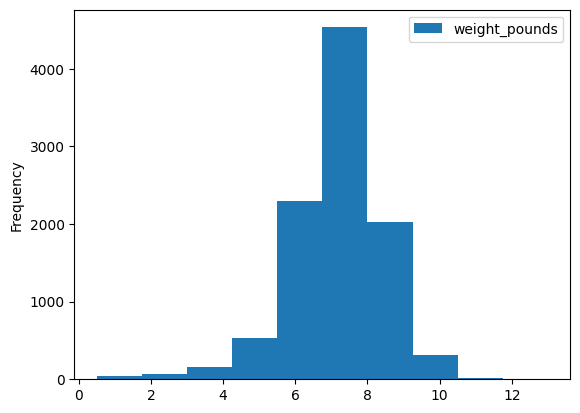

In [16]:
df.plot(kind='hist')

In the main dataset,

* Babies <3 lbs in weight account for ~0.06% of data
* Babies <12 lbs account for ~0.05% of data

To get good performance over the entire range, a combination of downsampling and reframing can be used. Split into 3 buckets:

1. underweight
2. average
3. overweight

In [22]:
%%bigquery
SELECT
  CASE
   WHEN weight_pounds < 5.5 THEN "underweight"
   WHEN weight_pounds > 9.5 THEN "overweigth"
  ELSE
    "average"
END
  AS weight,
  COUNT(*) as num_examples,
  round(COUNT(*) / sum(COUNT(*)) over(), 4) as percent_of_dataset
FROM
  `bigquery-public-data.samples.natality`
GROUP BY
  1

,weight,num_examples,percent_of_dataset
0,underweight,9649724,0.0700
1,average,123781044,0.8981
2,overweigth,4395995,0.0319
